# Evaluate & Visualize
This notebook is a helpful walkthrough of evaluating the MD surrogate and visualizing the results. There are four visualizations that will be shown:
1. Trajectory rollout (Ground Truth and Predicted)
2. True rollout with acceleration vectors (per step comparison)
3. Per step & rollout losses
4. Energies

The model definition and datasets used are defined by the `config` file which was used to train the model. Of course, those variables can be modified in the notebook if needed.

In [1]:
import numpy as np
import vis_utils
import learned_simulator_graph
from args import Arguments
import tensorflow as tf
import utils_md
from train_md import gen_data
from graph_nets import utils_tf
import matplotlib.pyplot as plt
import yaml

## Model definition
The weights are saved with `tf.checkpoint` and thus the model must be redefined with the same structure in which we trained so the weights can be updated accordingly. We grab the training configurations from the config file which defined the training parameters (`config.yaml`), set a couple other necessary parameters, define our model, and update the weights.

In [2]:
# region load arguments and define model
# load training parameters
args = yaml.safe_load(open('config.yaml', 'r'))
args = Arguments.dict_to_namespace(args)

system_size = np.array([
    [args.unit_cell.xlo, args.unit_cell.ylo],
    [args.unit_cell.xhi, args.unit_cell.yhi]
])

# the following two simulator parameters (num_dimensions, seq_length) should be kept constant (2, 1)
num_dimensions = 2
seq_length = 1

model_kwargs = dict(
    latent_size=args.latent_size,
    mlp_hidden_size=args.mlp_hidden_size,
    mlp_num_hidden_layers=args.mlp_num_hidden_layers,
    num_message_passing_steps=args.num_message_passing_steps
)

# define model
model = learned_simulator_graph.LearnedSimulator(
        num_dimensions, args.step_size, system_size, args.cutoff, model_kwargs)
simulator = utils_md.MolecularDynamicsSimulatorGraph(
        step_size=args.step_size, system_size=system_size, cutoff=args.cutoff, integrator='verlet')

weights_path = args.model_save_directory.parent + args.model_save_directory.child + 'weights-1'
utils_md.load_weights(model, weights_path)
# endregion load arguments and define model

## Data
The data used will come from the `test_set` parameters in the `config.yaml` file. A set of `batch_size` graphs will be randomly generated with no less than `min_num_atoms` and no more than `man_num_atoms`.

In [3]:
# region define data

# get systems and define graphs
static_graph, num_atoms = gen_data(
    args.test_set.batch_size, args.test_set.min_num_atoms, args.test_set.max_num_atoms+1, system_size)
base_graph = utils_tf.data_dicts_to_graphs_tuple(static_graph)
# endregion define data

# region get rollouts

# Apply noise & get true rollout
initial_conditions, true_trajectory, true_accelerations = utils_md.generate_trajectory(
    simulator,
    base_graph,
    args.num_time_steps,
    edge_noise_level=0.1,
    seq_length=seq_length
)

# initialize model acceleration
model._acceleration = simulator.get_step_accelerations(
    initial_conditions, initial_conditions.nodes[..., :2])

# get predicted rollout
_, pred_trajectory, pred_accelerations = utils_md.rollout_dynamics(
    model, initial_conditions, args.num_time_steps, seq_length)

# get the per step predicted rollout updated along the true rollout
# this will help in evaluating the model without accumulation error
per_step_trajectory = np.ones_like(true_trajectory)
per_step_trajectory[0] = true_trajectory[0]
per_step_accelerations = np.ones_like(true_accelerations[..., :2])
for i in range(true_trajectory.shape[0]-1):
    initial_conditions = initial_conditions.replace(nodes=true_trajectory[i])
    model._acceleration = simulator.get_step_accelerations(initial_conditions, initial_conditions.nodes[..., :2])
    if i == 0:
        per_step_accelerations[0] = model._acceleration
    _, next_step, acc = utils_md.rollout_dynamics(
        model, initial_conditions, 1, seq_length
    )
    per_step_trajectory[i+1] = next_step[-1]
    per_step_accelerations[i+1] = acc[-1]

# endregion get rollouts

## Visualize
We will pick a system from the batch to visualize by choosing an index, for example `id = 4`. If a system with a specific number of atoms is desired, print the output of `initial_conditions.n_node` and choose the corresponding index (or use `np.where`).



### Animations
There are two animations - (1) Ground truth and predicted rollouts & (2) True rollout with ground truth and predicted accelerations. The purpose of (2) is to visualize the results of the model without the accumulation of errors that are found in the rollouts. Remember, the model is trained on single step losses, thus it is beneficial to visualize the single step performance.

The colors chosen for each atom are random. If the color choice is poor, run again and hope for the best.

The animations are saved to file defined by `outpath`. If an `outpath` is *not* given, the animation will be displayed in the notebook. This raises issues on my personal system (Mac M2, python 3.10), thus I recommend saving and viewing.

In [4]:
# compile data
true_rollouts = np.dstack([true_trajectory, true_accelerations])
pred_rollouts = np.dstack([pred_trajectory, pred_accelerations])
per_step_rollouts = np.dstack([per_step_trajectory, per_step_accelerations])
nodes_split_true = vis_utils.get_node_trajectories(true_rollouts, np.cumsum(initial_conditions.n_node))
nodes_split_pred = vis_utils.get_node_trajectories(pred_rollouts, np.cumsum(initial_conditions.n_node))
nodes_split_step = vis_utils.get_node_trajectories(per_step_rollouts, np.cumsum(initial_conditions.n_node))

id = 4  # index of system from batch to plot

# region animations

# rollouts
vis_utils.animate_two_trajectory(
    nodes_split_true[id], nodes_split_pred[id], system_size, titles=['True', 'Predicted'],
    outpath=f'./demo_trajectory_{id}', fps=25)

# per step acceleration vectors
vis_utils.animate_trajectory_with_acc(
    nodes_split_true[id], nodes_split_step[id], system_size,
    outpath=f'./demo_accelerations_{id}', fps=25)

# endregion animations



### Losses
Single step and rollout losses for a single test system are visualized. Keep in mind, the axis limits are automatically scaled.

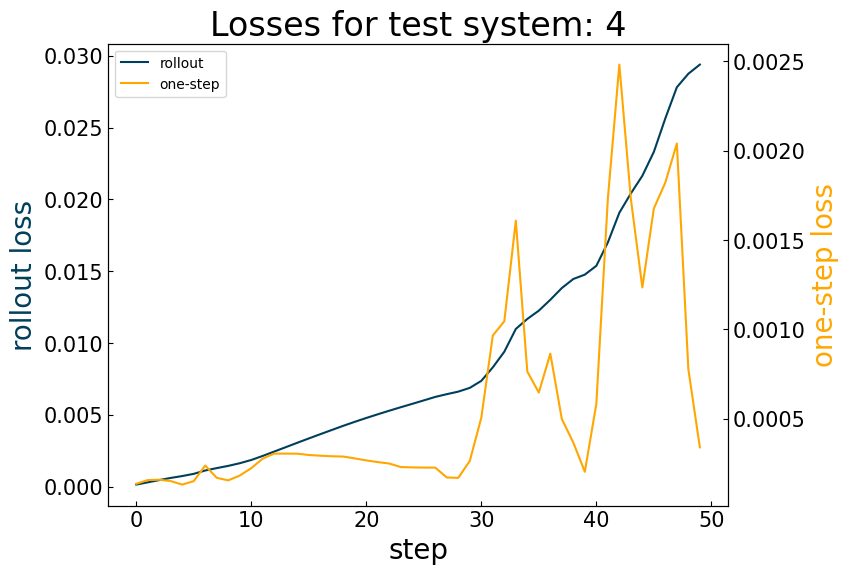

In [5]:
# region losses
def get_per_step_loss(target, output):
    """ MSE between target and predicted accelerations """
    loss = np.mean(np.sum((output - target)**2, axis=-1), axis=1)
    return loss


one_step_loss = get_per_step_loss(nodes_split_true[id][..., -2:], nodes_split_step[id][..., -2:])
rollout_loss = get_per_step_loss(nodes_split_true[id][..., -2:], nodes_split_pred[id][..., -2:])
rollout_loss = np.cumsum(rollout_loss)

fig, ax = plt.subplots(figsize=(8,6))
line1, line2, _ = vis_utils.plot_losses(rollout_loss[1:], one_step_loss[1:], ax)
ax.set_title(f'Losses for test system: {id}', fontsize=24)
ax.legend([line1, line2], [line1.get_label(), line2.get_label()])
fig.savefig(f'./demo_losses_{id}.png', bbox_inches='tight')

# endregion losses

### Energies
Energies per step for a single system are visualized. Dotted lines are predicted energies, solid lines are true energies.

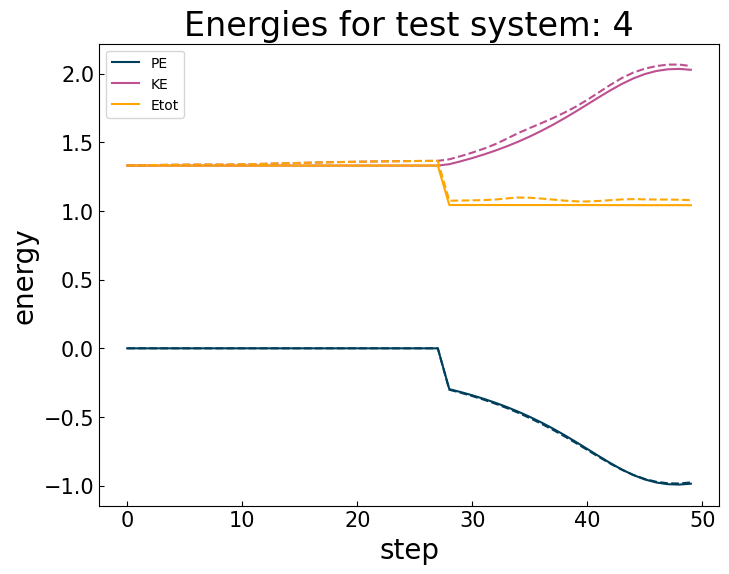

In [6]:
# region energies
def get_energies(trajectory, initial_graph, cutoff, lx, steps):
    kes, pes = [], []
    potential = utils_md.morse_potential
    for step in range(steps):
        current_state = trajectory[step+1, ...]
        receiver_nodes = tf.gather(current_state, initial_graph.receivers)
        sender_nodes = tf.gather(current_state, initial_graph.senders)
        pe, ke = utils_md.compute_energies(receiver_nodes, sender_nodes, initial_graph.edges,
                                           cutoff, lx, potential)
        kes.append(ke.numpy())
        pes.append(pe.numpy())

    return pes, kes

extracted_graph = utils_tf.get_graph(initial_conditions, id)
lx = system_size[1,0] - system_size[0,1]
true_pe, true_ke = get_energies(nodes_split_true[id][..., :5], extracted_graph, args.cutoff, lx, args.num_time_steps)
pred_pe, pred_ke = get_energies(nodes_split_pred[id][..., :5], extracted_graph, args.cutoff, lx, args.num_time_steps)

fig, ax = plt.subplots(figsize=(8,6))
true_energies = np.stack([true_pe, true_ke], axis=1)
pred_energies = np.stack([pred_pe, pred_ke], axis=1)
_ = vis_utils.plot_energies(true_energies, ax, pred_energies )
ax.set_title(f"Energies for test system: {id}", fontsize=24)
fig.savefig(f'./demo_energies_{id}.png', bbox_inches='tight')

# endregion energies